Run this first, contains functions to be called

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import math
from IPython.display import clear_output

# convert maze to binary
def get_maze_array(image_file):
    # Open the image file and convert it to grayscale
    maze = Image.open(image_file).convert('L')

    # Get the size of the maze image
    cols, rows = maze.size

    # Convert the image to a binary matrix
    binary_matrix = maze.point(lambda p: p > 127 and 1)

    # Resize the binary matrix
    binary_matrix = binary_matrix.resize((cols//2, rows//2), Image.NEAREST)

    # Get the new size of the resized matrix
    cols, rows = binary_matrix.size

    # Convert the binary matrix to a numpy array
    maze_array = np.array(binary_matrix)

    return maze_array

# flip the maze for row indexing easier display, maze understanding, and calculations
def flip_for_displaying(mazearray,maze_row_size,maze_col_size):
  temp_mazearray = np.zeros((maze_row_size,maze_col_size))
  for i in range(maze_row_size):
    for j in range(maze_col_size):
      temp_mazearray[i,j] = mazearray[maze_row_size-i-1,j] # flips maze row indices

  return temp_mazearray

# convert array with size 10 walls to 1
def shrink_array(mazearray,factor,maze_row_size,maze_col_size):
  temp_mazearray = np.zeros((int(maze_row_size/factor),int(maze_col_size/factor)))
  for i in range(maze_row_size):
    for j in range(maze_col_size):
     if i % factor == 0 or j % factor == 0:
      row = int(i / factor);
      col = int(j / factor);
      temp_mazearray[row,col] = mazearray[i,j]

  return temp_mazearray

# plot maze array from image
def plot_examples(colormaps,data,solved):
    """
    Helper function to plot data with associated colormap.
    """
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, vmin=0, vmax=2)
    if(solved == True):
      plt.savefig('solvedmaze.png')
    plt.show()

# create reward matrix
def reward_matrix(P,maze_row_size,maze_col_size,endI,endJ):
  temp = np.zeros((len(P[0,:]),len(P[0,:]),4))
  n_states = maze_col_size * maze_row_size
  size = 1
  maze_input_size = (math.sqrt(n_states)) - 1 / 2

  if(maze_input_size > 10): # reward value dependent on maze size
    size = maze_input_size / 10

  for i in range(len(P[:,0])):
    for j in range(len(P[0,:])):
      for a in range(4):
        if(P[i,j,a] == 0):
          temp[i,j,a] = -pow(10,size)
        else:
          temp[i,j,a] =  pow(100,size)

  temp[endI*maze_col_size + endJ,endI*maze_col_size + endJ,:] = pow(10,size) # reward for ending location

  return temp

# create transition matrices for up/down/left/right
def create_transition_matrices(smaller_mazearray,maze_row_size,maze_col_size,endI,endJ):
  up_matrix = np.zeros((maze_row_size*maze_col_size,maze_row_size*maze_col_size))
  down_matrix = np.zeros((maze_row_size*maze_col_size,maze_row_size*maze_col_size))
  left_matrix = np.zeros((maze_row_size*maze_col_size,maze_row_size*maze_col_size))
  right_matrix = np.zeros((maze_row_size*maze_col_size,maze_row_size*maze_col_size))

  states = np.zeros(maze_row_size*maze_col_size)

  counter = 0
  for i in range(maze_row_size):
    for j in range(maze_col_size):
      states[counter] = smaller_mazearray[i,j]
      counter = counter + 1

  # fill transition matrices for up/down/left/right
  for i in range(maze_row_size*maze_col_size):
    if i > (maze_col_size - 1): # up
      if (states[i] == 1) and (states[i - maze_col_size] == 1):
        up_matrix[i][i - maze_col_size] = 1
    if i < maze_row_size*maze_col_size - maze_col_size: # down
      if (states[i] == 1) and (states[i + maze_col_size] == 1):
        down_matrix[i][i + maze_col_size] = 1
    if i % maze_col_size != 0: # left
      if (states[i] == 1) and (states[i-1] == 1):
        left_matrix[i][i - 1] = 1
    if i % maze_col_size != (maze_col_size - 1): # right
      if (states[i] == 1) and (states[i+1] == 1):
        right_matrix[i][i + 1] = 1

  P = np.zeros((maze_row_size*maze_col_size,maze_row_size*maze_col_size,4))
  # transition probabiltiy when at end location is 1 to stay at end
  up_matrix[endI*maze_col_size + endJ,endI*maze_col_size + endJ] = 1
  down_matrix[endI*maze_col_size + endJ,endI*maze_col_size + endJ] = 1
  left_matrix[endI*maze_col_size + endJ,endI*maze_col_size + endJ] = 1
  right_matrix[endI*maze_col_size + endJ,endI*maze_col_size + endJ] = 1
  P[:,:,0] = up_matrix
  P[:,:,1] = down_matrix
  P[:,:,2] = left_matrix
  P[:,:,3] = right_matrix
  return P

# value iteration step
def value_iteration_step(reward_togo_t,Pssa,Rssa,gamma):
  reward_togo_t_minus_1 = np.zeros(reward_togo_t.shape)
  reward_togo_t_minus_1 = np.dot(Pssa,Rssa) + gamma*reward_togo_t
  return reward_togo_t_minus_1

def find_optimal_path(smaller_mazearray,P,R,maze_row_size,maze_col_size):
  n_states = maze_row_size*maze_col_size
  n_actions = 4
  epsilon = 0.0001
  counter = 1
  policy_pi = np.array(np.random.randint(0,n_actions,n_states))

  reward_togo = np.zeros(n_states) # "vector" to hold rewards

  # gamma dependent on maze size, larger mazes need more iterations and thus larger gamma
  gamma = 0.9
  if(n_states > 150):
    gamma = 0.99

  reward_k_minus_1 = reward_togo[maze_col_size] # value to compare to to check for convergence
  while True:
    reward = np.zeros(n_states) #to hold the max reward for each state before reassigning all values to reward array
    for s in range(n_states-1,-1,-1): # loop through states
      temp_reward = np.zeros(n_actions) # temp array to hold rewards for each action for state s in order to get max
      for a in range(n_actions): # calc rewards for state s given each action a
        if(a == 0 and s > maze_col_size):
          temp_reward[a] = value_iteration_step(reward_togo[s-maze_col_size],P[s,:,a],R[s,:,a],pow(gamma,counter))
        if(a == 1 and s < maze_row_size*maze_col_size - maze_col_size):
          temp_reward[a] = value_iteration_step(reward_togo[s+maze_col_size],P[s,:,a],R[s,:,a],pow(gamma,counter))
        if(a == 2 and s % maze_col_size != 0):
          temp_reward[a] = value_iteration_step(reward_togo[s-1],P[s,:,a],R[s,:,a],pow(gamma,counter))
        if(a == 3 and s %  maze_col_size !=  maze_col_size - 1):
          temp_reward[a] = value_iteration_step(reward_togo[s+1],P[s,:,a],R[s,:,a],pow(gamma,counter))
      policy_pi[s] = np.argmax(temp_reward) # get policy corresponding to max state
      reward[s] = max(temp_reward) # get max reward from optimal policy
    reward_togo = reward # update reward array with each states max reward from optimal action
    print("Epsilon:",abs(reward[maze_col_size] - reward_k_minus_1))
    if abs(reward_togo[maze_col_size] - reward_k_minus_1) < epsilon: # check for convergence
      break
    reward_k_minus_1 = reward_togo[maze_col_size]
  return policy_pi

# prepares maze for value iteration by finding sizes, transition & reward matrices, etc. and calls function to get optimal policy and then returns it
def find_policy(mazearray):
  maze_row_size = len(mazearray[:,0]) # the number of rows in maze
  maze_col_size = len(mazearray[0,:]) # the number of columns in maze

  cmap = ListedColormap(["black", "white"]) # color mapping for displaying maze
  factor = 5 # factor for converting size 10 thickness walls of maze to 1
  smaller_mazearray = shrink_array(mazearray,factor,maze_row_size,maze_col_size) # reduce maze walls thickness to be 1

  maze_row_size = len(smaller_mazearray[:,0]) # the number of rows in shrunken maze
  maze_col_size = len(smaller_mazearray[0,:]) # the number of columns in shrunken maze

  plot_examples([cmap],flip_for_displaying(smaller_mazearray,maze_row_size,maze_col_size),False) # displays intitial maze

  endI = maze_row_size - 2 # ending location row index
  endJ = maze_col_size - 1 # ending location column index

  # gets transition and reward matrices
  P = create_transition_matrices(smaller_mazearray,maze_row_size,maze_col_size,endI,endJ)
  R = reward_matrix(P,maze_row_size,maze_col_size,endI,endJ)

  # get the optimal policy by finding optimal path
  policy_pi = find_optimal_path(smaller_mazearray,P,R,maze_row_size,maze_col_size)

  # clear epsilon output, display plot, and return optimal policy
  clear_output(wait=True)
  plot_examples([cmap],flip_for_displaying(smaller_mazearray,maze_row_size,maze_col_size),False)
  return policy_pi

# displays path for solved maze
def output_result(mazearray, policy_pi):
  maze_row_size = len(mazearray[:,0]) # the number of rows in maze
  maze_col_size = len(mazearray[0,:]) # the number of columns in maze

  factor = 5 # factor for converting size 10 thickness walls of maze to 1

  smaller_mazearray = shrink_array(mazearray,factor,maze_row_size,maze_col_size)  # reduce maze walls thickness to be 1

  maze_row_size = len(smaller_mazearray[:,0]) # the number of rows in shrunken maze
  maze_col_size = len(smaller_mazearray[0,:]) # the number of columns in shrunken maze

  endI = maze_row_size - 2 # ending location row index
  endJ = maze_col_size - 1 # ending location column index

  start = (1,0) # maze starting coordinated
  end = (endI,endJ) # maze ending coordinate

  location = start[0] * maze_col_size + start[1] # variable for current state location
  locationCord = start
  smaller_mazearray[start] = 2 # path to end will be values of 2 for displaying

  # uses optimal policy to go through maze to get to end and assigns maze array values to be 2 allong path for displaying
  while(True):
    next_move = policy_pi[location]
    if(next_move == 0):
      location = location - maze_col_size
    if(next_move == 1):
      location = location + maze_col_size
    if(next_move == 2):
      location = location - 1
    if(next_move == 3):
      location = location + 1

    i = int(location / maze_col_size)
    j = location % maze_col_size
    locationCord = (i,j)

    smaller_mazearray[locationCord] = 2

    if(locationCord == end):
      break

  cmap = ListedColormap(["black", "white","red"])
  plot_examples([cmap],flip_for_displaying(smaller_mazearray,maze_row_size,maze_col_size),True)

Change filename variable to maze file name and run to get solved maze

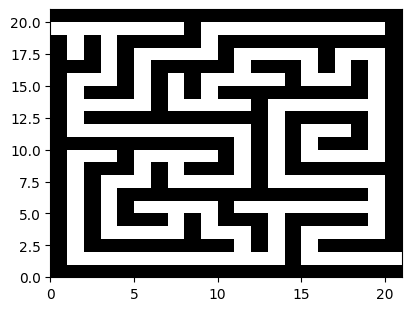

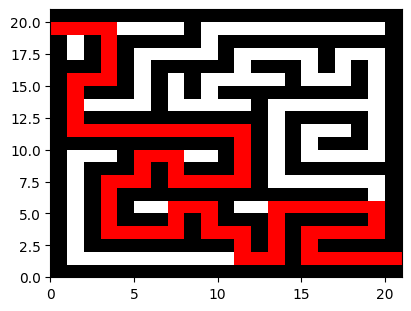

In [ ]:
# CHANGE THIS FILENAME TO BE FILE NAME OF DESIRED MAZE TO BE SOLVED
filename = 'maze (1).png'

# calls necessary functions to find optimal path
mazearray = get_maze_array(filename)
policy_pi = find_policy(mazearray)
output_result(mazearray,policy_pi)